In [1]:
options(warn = -1)

In [2]:
library(data.table)
library(tidyverse)
library(naniar)
library(knitr)
library(plotly)
library(ggridges)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──

✔ ggplot2 3.4.0      ✔ purrr   1.0.1 

✔ tibble  3.1.8      ✔ dplyr   1.0.10

✔ tidyr   1.2.1      ✔ stringr 1.5.0 

✔ readr   2.1.3      ✔ forcats 0.5.2 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──

✖ dplyr::between()   masks data.table::between()

✖ dplyr::filter()    masks stats::filter()

✖ dplyr::first()     masks data.table::first()

✖ dplyr::lag()       masks stats::lag()

✖ dplyr::last()      masks data.table::last()

✖ purrr::transpose() masks data.table::transpose()



Attaching package: ‘plotly’





The following object is masked from ‘package:ggplot2’:



    last_plot





The following object is masked from ‘package:stats’:



    filter





The following object is masked from ‘package:graphics’:



    layout





The following object is masked from ‘package:httr’:



    config






In [3]:
data <- fread("/kaggle/input/property-listing-data-in-bangladesh/property_listing_data_in_Bangladesh.csv")

In [4]:
extract_region <- function(string) {
  words <- str_split(string, ",\\s*")[[1]]
  word_length <- length(words)
  if (word_length > 2) {
    paste(words[(word_length-1) : word_length], collapse = ", ")
  } else {
    string
  }
}

data$region <- sapply(data$adress, extract_region)

In [5]:
data %>% 
  count(Region = region, sort = TRUE) %>% 
  slice_head(n = 10) %>% 
  rename(Count = n) %>%
  kable()



|Region                     | Count|
|:--------------------------|-----:|
|Uttara, Dhaka              |  1184|
|Mirpur, Dhaka              |   995|
|Double Mooring, Chattogram |   630|
|Dakshin Khan, Dhaka        |   346|
|Bashundhara R-A, Dhaka     |   333|
|Mohammadpur, Dhaka         |   306|
|Khulshi, Chattogram        |   277|
|Gulshan, Dhaka             |   205|
|Halishahar, Chattogram     |   205|
|Baridhara, Dhaka           |   198|

In [6]:
extract_division <- function(string) {
  words <- str_split(string, ",\\s*")[[1]]
  word_length <- length(words)
  return(ifelse(word_length == 2, words[2], words))
}

data$division <- sapply(data$region, extract_division)

In [7]:
data %>% 
  count(Division = division, sort = TRUE) %>% 
  rename(Count = n) %>%
  kable()



|Division   | Count|
|:----------|-----:|
|Dhaka      |  5332|
|Chattogram |  2225|

In [8]:
data$area <- as.numeric(gsub("[^0-9.]", "", data$area))

In [9]:
summary(data$area)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    300     900    1200    1372    1550   31500 

In [10]:
convert_price <- function(str) {
  if (grepl("Thousand", str)) {
    return(as.numeric(gsub("Thousand", "", str)) * 1000)
  } else if (grepl("Lakh", str)) {
    return(as.numeric(gsub("Lakh", "", str)) * 100000)
  }
}

In [11]:
data$price <- sapply(data$price, convert_price)
summary(data$price)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5500   15000   19000   34079   30000 2000000 

In [12]:
data <- data %>% 
  mutate(beds = as.numeric(gsub("[^0-9.]", "", beds)),
         bath = as.numeric(gsub("[^0-9.]", "", bath)))

data %>% 
  count(Beds = beds, sort = TRUE) %>% 
  slice_head(n = 10) %>%
  kable()



| Beds|    n|
|----:|----:|
|    3| 4386|
|    2| 2443|
|    4|  514|
|    1|  133|
|    5|   55|
|    7|   10|
|    6|    8|
|   20|    2|
|   21|    2|
|   17|    1|

In [13]:
data %>% 
  count(Baths = bath, sort = TRUE) %>% 
  slice_head(n = 10) %>%
  kable()



| Baths|    n|
|-----:|----:|
|     3| 3049|
|     2| 2959|
|     4|  996|
|     1|  387|
|     5|  131|
|     6|   14|
|     8|   10|
|    10|    8|
|     7|    3|

In [14]:
data <- data %>% mutate(type = factor(type))

In [15]:
data$lastUpdated <- as.Date(data$lastUpdated, format = "%B %d, %Y")

In [16]:
data <- data %>% 
  select(-title, -adress, -flooPlan, -url)

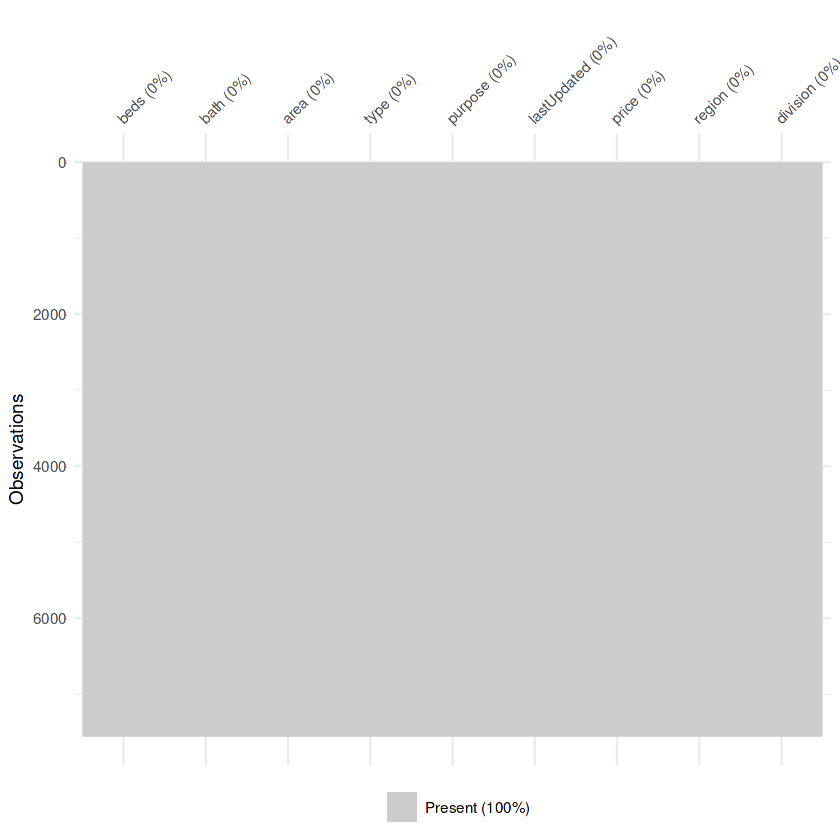

In [17]:
vis_miss(data)

In [18]:
summary_price <- data %>% 
  group_by(division, type) %>% 
  summarise(Count = n(),
            Average_price = mean(price),
            Minimum = min(price),
            Q1 = quantile(price, 0.25),
            Median_price = median(price),
            Q3 = quantile(price, 0.75),
            Maximum = max(price), .groups = "drop")

kable(summary_price)



|division   |type      | Count| Average_price| Minimum|     Q1| Median_price|      Q3| Maximum|
|:----------|:---------|-----:|-------------:|-------:|------:|------------:|-------:|-------:|
|Chattogram |Apartment |  2217|      19813.96|    5500|  12000|        16000|   22000|  130000|
|Chattogram |Building  |     1|      70000.00|   70000|  70000|        70000|   70000|   70000|
|Chattogram |Duplex    |     7|     105714.29|   25000|  42500|        60000|  135000|  300000|
|Dhaka      |Apartment |  5272|      35752.97|    7000|  15000|        20000|   33000|  924000|
|Dhaka      |Building  |    20|     696500.00|   40000| 387500|       550000| 1000000| 2000000|
|Dhaka      |Duplex    |    40|     259450.00|   30000|  80000|       135000|  350000| 1000000|

Picking joint bandwidth of 21800



Picking joint bandwidth of 105000




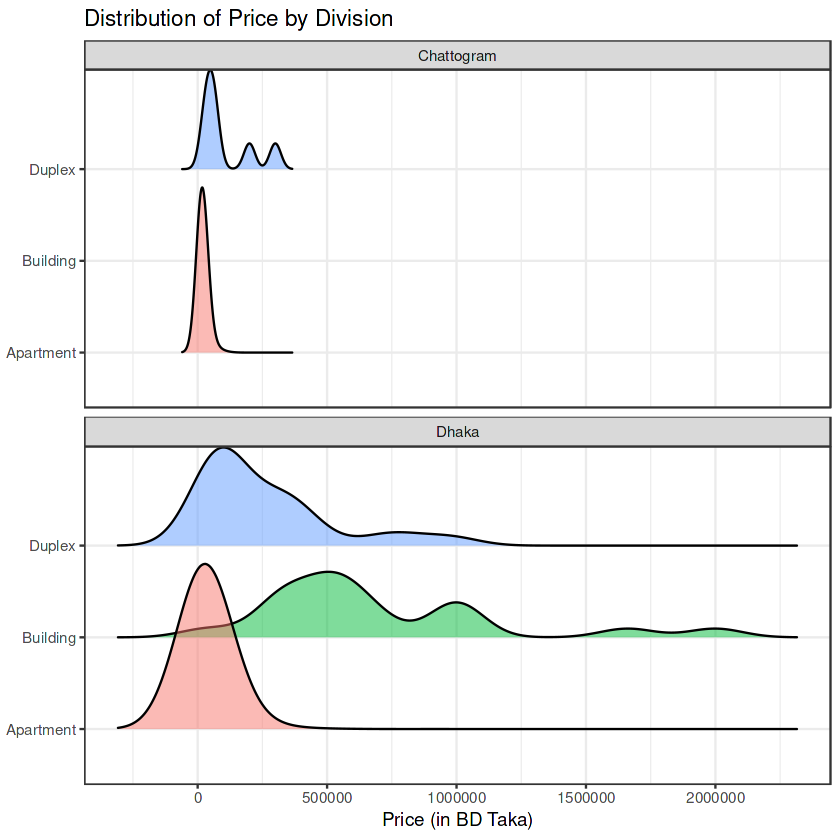

In [19]:
ggplot(data) +
  geom_density_ridges(aes(x = price, y = type, fill = type), 
                      alpha = 0.5) +
  facet_wrap(~division, nrow = 2) +
  theme_bw() +
  labs(x = "Price (in BD Taka)", y = NULL, 
       title = "Distribution of Price by Division") +
  guides(fill = FALSE)

In [20]:
data %>% 
  count(purpose) %>%
  kable()



|purpose  |    n|
|:--------|----:|
|For Rent | 7557|

In [21]:
tab_region <- data %>% 
  count(Region = region, sort = TRUE) %>% 
  slice_head(n = 10) %>% 
  rename(Count = n) %>%
  mutate(Percentage = round(Count/sum(Count),3))

kable(tab_region, digits = c(0,0,3))



|Region                     | Count| Percentage|
|:--------------------------|-----:|----------:|
|Uttara, Dhaka              |  1184|      0.253|
|Mirpur, Dhaka              |   995|      0.213|
|Double Mooring, Chattogram |   630|      0.135|
|Dakshin Khan, Dhaka        |   346|      0.074|
|Bashundhara R-A, Dhaka     |   333|      0.071|
|Mohammadpur, Dhaka         |   306|      0.065|
|Khulshi, Chattogram        |   277|      0.059|
|Gulshan, Dhaka             |   205|      0.044|
|Halishahar, Chattogram     |   205|      0.044|
|Baridhara, Dhaka           |   198|      0.042|

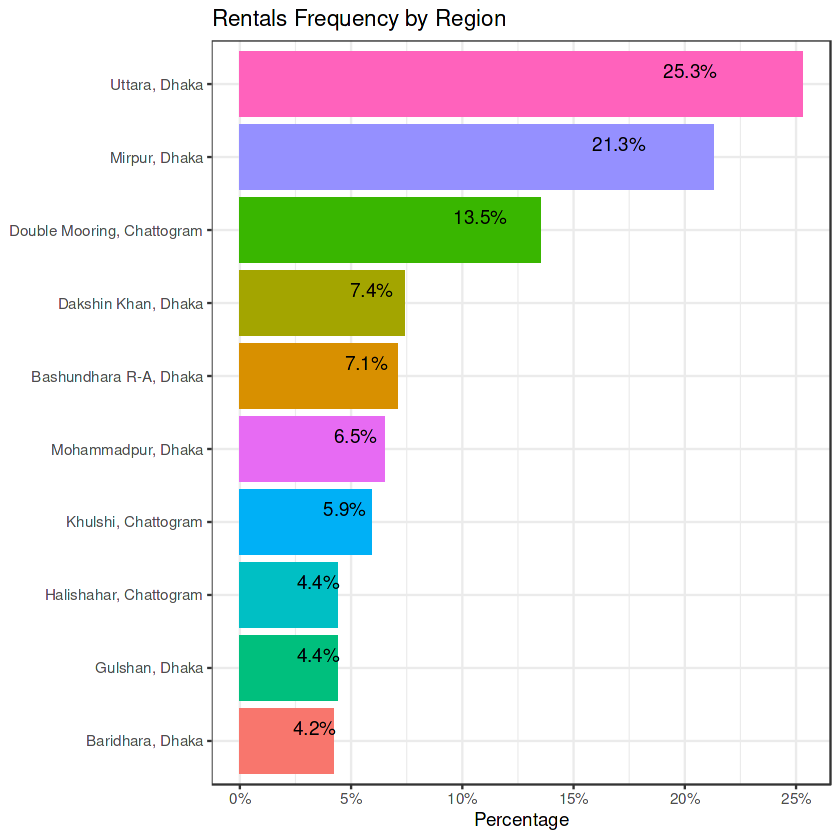

In [22]:
ggplot(tab_region,
       aes(
           y = reorder(Region, Percentage),
           x = Percentage,
           fill = Region
       )) +
  geom_col() + 
  scale_x_continuous(labels = scales::percent) +
  theme_bw() +
  labs(y = NULL, title = "Rentals Frequency by Region") +
  guides(fill="none") +
  geom_text(aes(label=paste0(Percentage*100,"%\n")),
            position = position_stack(vjust = 0.8))

In [23]:
tab_division <- data %>% 
  count(Division = division, sort = TRUE) %>% 
  rename(Count = n) %>% 
  mutate(Percentage = round(Count/sum(Count),3))

kable(tab_division, digits = c(0,0,3))



|Division   | Count| Percentage|
|:----------|-----:|----------:|
|Dhaka      |  5332|      0.706|
|Chattogram |  2225|      0.294|

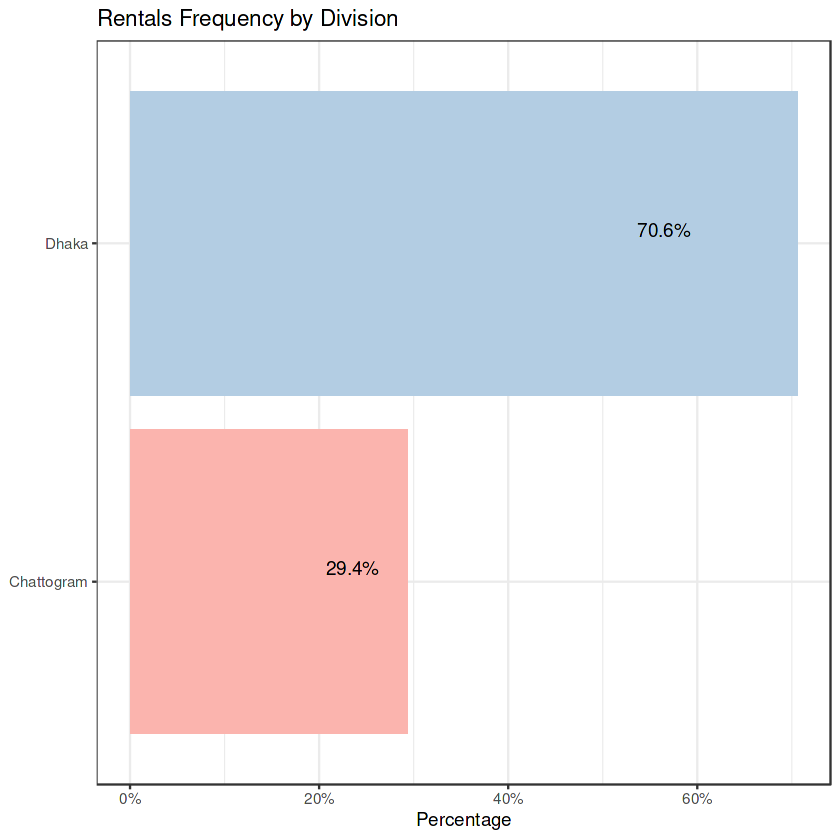

In [24]:
ggplot(tab_division,
       aes(
         y = reorder(Division, Percentage),
         x = Percentage,
         fill = Division
       )) +
  geom_col() + 
  scale_fill_brewer(palette="Pastel1") +
  scale_x_continuous(labels = scales::percent) +
  theme_bw() +
  labs(y = NULL, title = "Rentals Frequency by Division") +
  guides(fill="none") +
  geom_text(aes(label=paste0(Percentage*100,"%\n")), 
            position = position_stack(vjust = 0.8))

In [25]:
tab_type <- data %>% 
  count(`Type of Property` = type, sort = TRUE) %>% 
  rename(Count = n) %>% 
  mutate(Percentage = round(Count/sum(Count),3))

kable(tab_type, digits = c(0,0,3))



|Type of Property | Count| Percentage|
|:----------------|-----:|----------:|
|Apartment        |  7489|      0.991|
|Duplex           |    47|      0.006|
|Building         |    21|      0.003|

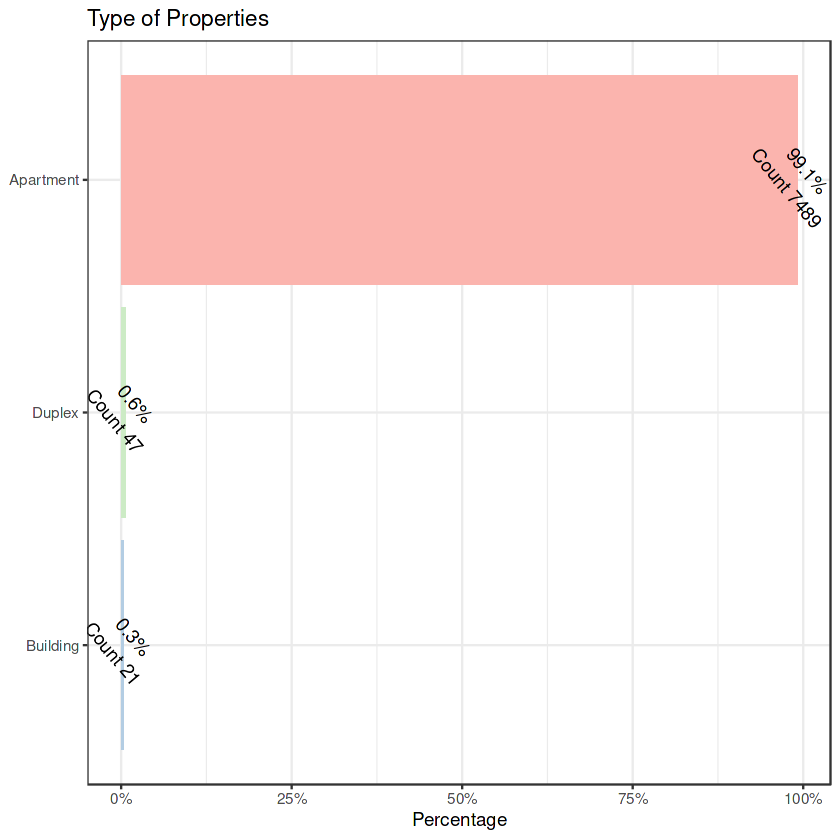

In [26]:
ggplot(tab_type,
       aes(
         y = reorder(`Type of Property`, Percentage),
         x = Percentage,
         fill = `Type of Property`
       )) +
  geom_col() + 
  scale_fill_brewer(palette="Pastel1") +
  scale_x_continuous(labels = scales::percent) +
  theme_bw() +
  labs(y = NULL, title = "Type of Properties") +
  guides(fill="none") +
  geom_text(aes(label=paste0(Percentage*100,"%\nCount ",Count)), angle = -50)

In [27]:
region_price_bottom10 <- data %>% 
  filter(type == "Apartment") %>% 
  group_by(Region = region) %>% 
  summarise(Count = n(),
            Average_rent = mean(price), 
            Median_rent = median(price),
            Average_area = mean(area)) %>% 
  arrange(Median_rent) %>% 
  slice_head(n = 10)

kable(region_price_bottom10, digits = c(0,0))



|Region                                | Count| Average_rent| Median_rent| Average_area|
|:-------------------------------------|-----:|------------:|-----------:|------------:|
|Demra, Dhaka                          |     2|         7250|        7250|          625|
|Hathazari, Chattogram                 |     3|         8833|       10000|          850|
|Patenga, Chattogram                   |    21|        12071|       11000|          788|
|10 No. North Kattali Ward, Chattogram |    39|        13551|       12000|          929|
|Jatra Bari, Dhaka                     |     1|        12000|       12000|          800|
|Kachukhet, Dhaka                      |     1|        12000|       12000|          650|
|Uttar Khan, Dhaka                     |   160|        12212|       12000|          856|
|Khilkhet, Dhaka                       |    54|        13500|       12250|          784|
|Nasirabad C and B Colony, Chattogram  |     1|        12500|       12500|          800|
|11 No. South Katta

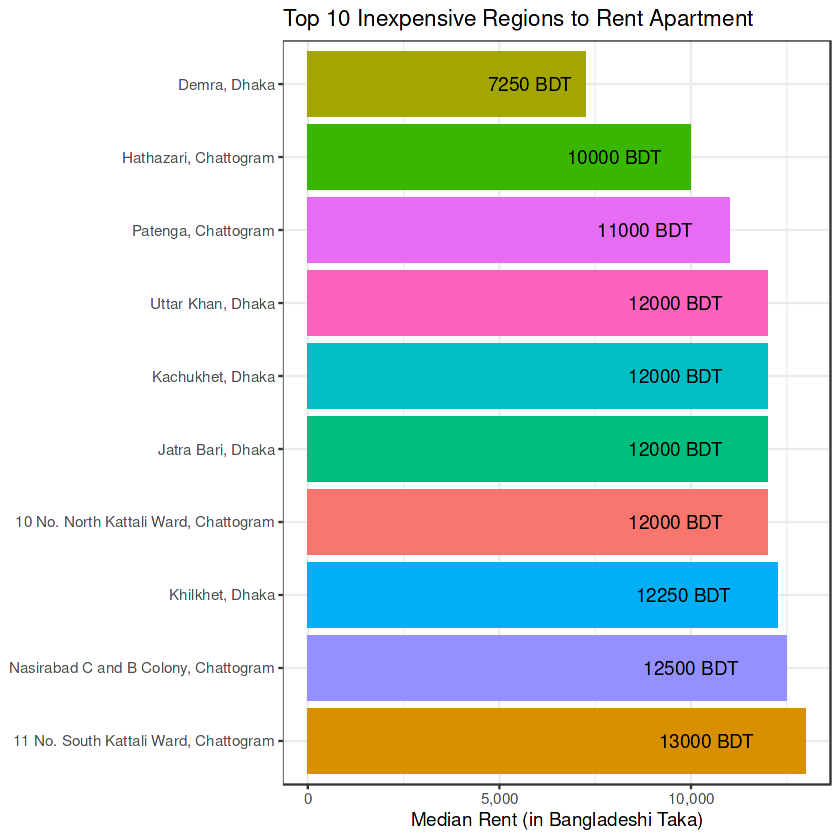

In [28]:
ggplot(region_price_bottom10,
       aes(
         y = reorder(Region, desc(Median_rent)),
         x = Median_rent,
         fill = Region
       )) +
  geom_col() + 
  theme_bw() +
  labs(y = NULL, title = "Top 10 Inexpensive Regions to Rent Apartment",
       x = "Median Rent (in Bangladeshi Taka)") +
  guides(fill="none") + scale_x_continuous(labels = scales::label_comma()) +
  geom_text(aes(label=paste(Median_rent,"BDT")), position = position_stack(vjust = 0.8))

In [29]:
region_price_top10 <- data %>% 
  filter(type == "Apartment") %>%
  group_by(Region = region) %>% 
  summarise(Count = n(),
            Average_rent = mean(price), 
            Median_rent = median(price),
            Average_area = mean(area)) %>% 
  arrange(desc(Median_rent)) %>% 
  slice_head(n = 10)

kable(region_price_top10, digits = c(0,0))



|Region                | Count| Average_rent| Median_rent| Average_area|
|:---------------------|-----:|------------:|-----------:|------------:|
|Gulshan, Dhaka        |   193|       159554|      140000|         2997|
|Baridhara, Dhaka      |   186|       164441|      138500|         2845|
|Banani DOHS, Dhaka    |    19|       118947|      110000|         2631|
|Banani, Dhaka         |    63|       110429|       90000|         2347|
|Shahbagh, Dhaka       |     3|        95000|       90000|         2800|
|Mohakhali DOHS, Dhaka |    10|        73500|       82500|         2155|
|Baridhara DOHS, Dhaka |    38|        71105|       70000|         1983|
|Niketan, Dhaka        |     7|        56857|       65000|         1694|
|Dhanmondi, Dhaka      |   102|        55304|       47500|         1721|
|Lalmatia, Dhaka       |     8|        50625|       45000|         1735|

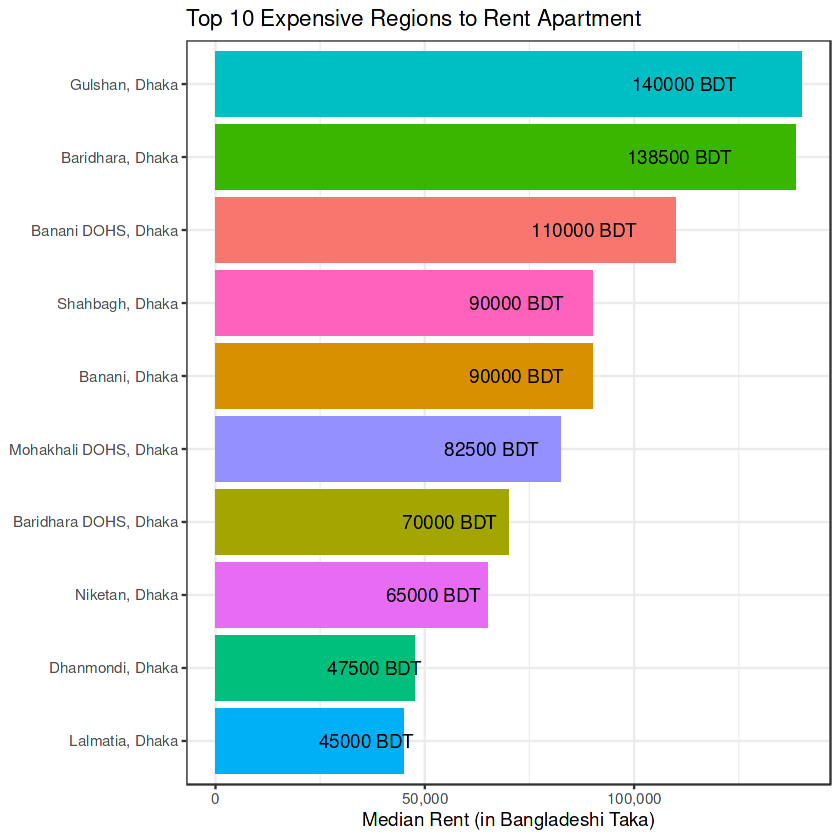

In [30]:
ggplot(region_price_top10,
       aes(
         y = reorder(Region, Median_rent),
         x = Median_rent,
         fill = Region
       )) +
  geom_col() + 
  theme_bw() +
  labs(y = NULL, title = "Top 10 Expensive Regions to Rent Apartment",
       x = "Median Rent (in Bangladeshi Taka)") +
  guides(fill=FALSE) + scale_x_continuous(labels = scales::label_comma()) +
  geom_text(aes(label=paste(Median_rent,"BDT")), position = position_stack(vjust = 0.8))

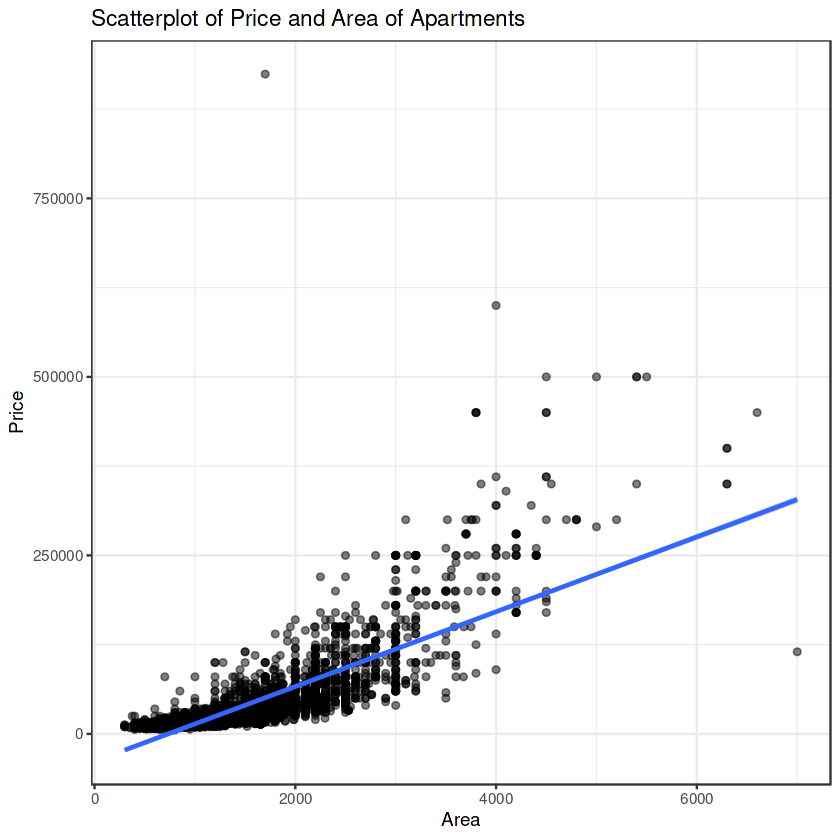

In [31]:
data %>% 
  filter(type == "Apartment") %>% 
  ggplot(aes(x = area, y = price)) +
  geom_point(alpha = 0.5) +
  geom_smooth(method = "lm", formula = "y ~ x") +
  labs(x = "Area", y = "Price", color = "Division",
       title = "Scatterplot of Price and Area of Apartments") +
  theme_bw()

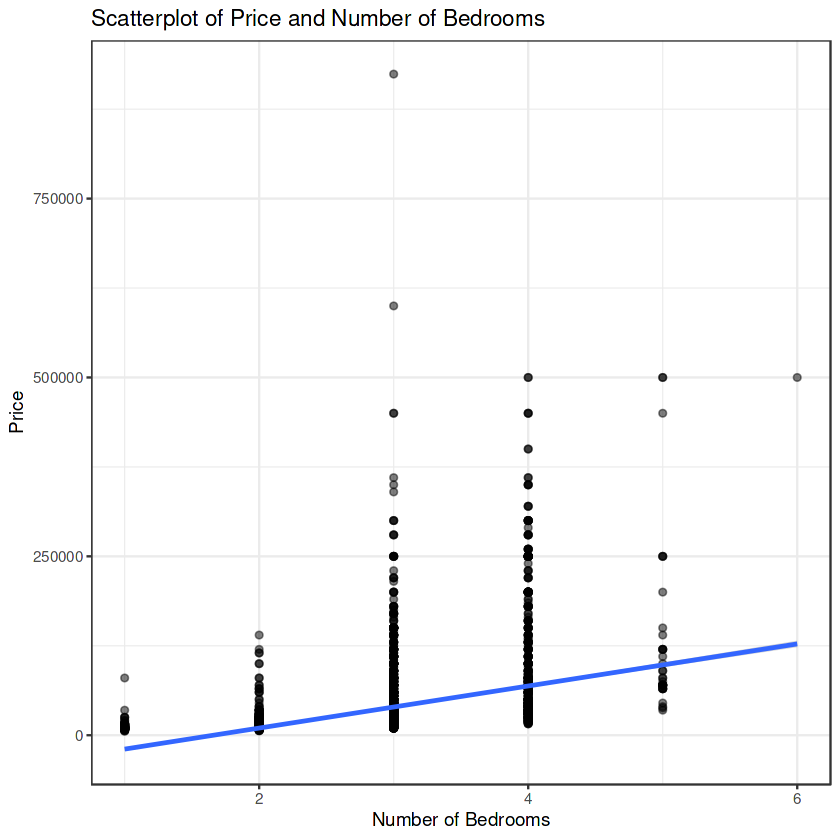

In [32]:
data %>% 
  filter(type == "Apartment") %>% 
  ggplot(aes(x = beds, y = price)) +
  geom_point(alpha = 0.5) +
  geom_smooth(method = "lm", formula = "y ~ x") +
  labs(x = "Number of Bedrooms", y = "Price", color = "Division",
       title = "Scatterplot of Price and Number of Bedrooms") +
  theme_bw()

In [33]:
model1 <- lm(price ~ area, data)
model2 <- lm(price ~ beds, data)
model3 <- lm(price ~ area + beds + bath + type + division, data)
stargazer::stargazer(model1, model2, model3, type = "text")




                                                    Dependent variable:                                 

                    ------------------------------------------------------------------------------------

                                                           price                                        

                                (1)                          (2)                         (3)            

--------------------------------------------------------------------------------------------------------

area                         57.780***                                                70.114***         

                              (0.404)                                                  (0.747)          

                                                                                                        

beds                                                    41,505.350***              -10,031.160***       

                                           